In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import poisson


def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))


yerr: 1.4142135623730951
xerr: 0.05
distance [10, 20, 30, 40, 50]
counts: [1095  284   94   29   16]
counts per solid angle [11641.95733416 11875.10485413  8815.58269717  4829.64171848
  4161.33620971]
coefficient 112673.96684120414 -26.221739867548564
coefficient error [175.15305251   0.81417044]
errors of cpsd: [3045.8239741  1323.24894313  315.72299875  371.91309915  658.27055255]


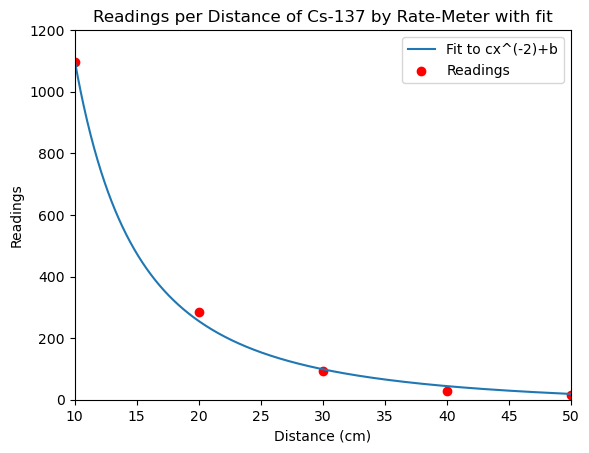

In [2]:
#Dose rate of a Cesium Source as a funciton of distance

dist = [10,20,30,40,50] #cm
dist_err = 0.05

back = np.full(np.size(dist),59)

back_err = 1

total = [1154,343,153,88,75] #counts
total_err = 1

def f(x,y):
    return x-y

results = f(total,back)
result_err = np.full(np.size(dist),np.sqrt(2))

#exponential fit
def invpoly(x,c,b):
    return c/(x**2) + b

popt,pcov = curve_fit(invpoly,dist,results,sigma = result_err, absolute_sigma = True)

c,b = popt
c_err = np.sqrt(np.diag(pcov))

def fit(x):
    return c/(x**2) + b

x = np.linspace(10,50,1000)

D = np.array([10,20,30,40,50])
d = np.array([3.5,3.5,3.5,3.5,3.5])

def omega(D):
    return 2 * np.pi*(1- 1/(np.sqrt(1+(d/(2*D))**2)))

#plt.plot(d,results)

def domega_dD(D, d):
    return - (np.pi * d**2) / (2 * D**3 * (1 + (d / (2 * D))**2)**(3/2))

def propagated_error(N_tot, N_back, sigma_N, D, sigma_D, d):
    w = omega(D)
    dw_dD = domega_dD(D, d)

    # Variance from counts and distance
    sigma_f_sq = ((sigma_N**2 + sigma_N**2) / w**2) + \
                 (((N_tot - N_back) / w**2 * dw_dD * sigma_D)**2)

    return np.sqrt(sigma_f_sq)

d = 3.5                 
sigma_D = np.sqrt(2)    
sigma_N = 0.5           

D_values = np.array([10, 20, 30, 40, 50])
N_tot = np.array([1095, 284, 94, 29, 16])
N_back = 59

errors = propagated_error(N_tot, N_back, sigma_N, D_values, sigma_D, d)
    

plt.plot(x,fit(x),label = 'Fit to cx^(-2)+b')
plt.ylim(0,1200)
plt.xlim(10,50)  
plt.title('Readings per Distance of Cs-137 by Rate-Meter with fit')
plt.scatter(dist,results,label='Readings', color = 'red')
plt.ylabel('Readings')
plt.xlabel('Distance (cm)')

plt.legend()
print('yerr:',np.sqrt(2))
print('xerr:',0.05)

print('distance',dist)

print('counts:', total-back)

print('counts per solid angle', (total-back)/omega(D))

print('coefficient', c,b)
print('coefficient error', c_err)
print('errors of cpsd:',errors)
plt.savefig('act_approx.png')

# GAUSSIAN FITS

In [3]:

def normaliser(llim,rlim,energy,reading):
    #boundaries
    for i in range(len(energy)):
        if llim < energy[i]:
            l = i
            break
    for i in range(len(energy)):
        if rlim < energy[l+i]:
            r = l+i
            break
    x = np.linspace(energy[l],energy[r-1],r-l)
    #print(x)
    a,b = np.polyfit([energy[l],energy[r]],[reading[l],reading[r]],1)
    print(reading[l],reading[r])
    linear_fit = a*x+b
    #plt.plot(x,linear_fit)
    return l,r, linear_fit
    
     
def raw_data(file1,file2,xlim,ylim,scint):
    df = pd.read_csv(file1, delim_whitespace=True)
    energy1 = df['Energy'].to_numpy()#MeV
    reading1 = df['Readings'].to_numpy()
    df = pd.read_csv(file2, delim_whitespace=True)
    energy2 = df['Energy'].to_numpy()#MeV
    reading2 = df['Readings'].to_numpy()
    plt.grid(True, alpha = 0.3)
    plt.ylabel('Number of Detections [#]')
    plt.xlabel('Photon Energy [keV]')
    plt.xlim(0,xlim)
    plt.ylim(0,ylim)
    plt.plot([121,121],[0,10000],label = '121 keV', alpha = 0.5)
    plt.plot([244,244],[0,10000],label = '244 keV', alpha = 0.5)
    plt.plot([344,344],[0,10000],label = '344 keV', alpha = 0.5)
    plt.plot([662,662],[0,10000],label = '662 keV', alpha = 0.5)
    plt.plot(energy1,reading1,label = 'Cs-137')
    plt.plot(energy2,reading2, label = 'Eu-152')
    plt.legend()
    if scint == True:
        plt.title('Calibration Choices for the Scintillation detector NaI(TI)')
        plt.savefig('cal_scint.png')
    else:
        plt.title('Calibration Choices for the Semiconductor detector ')
        plt.savefig('cal_germ.png')

def raw(file1,filename,title,xlim,ylim,g_xlim):
    df = pd.read_csv(file1, delim_whitespace=True)
    
    energy1 = df['Energy'].to_numpy()#MeV
    reading1 = df['Readings'].to_numpy()
    plt.figure()
    plt.grid(True, alpha = 0.3)
    plt.ylabel('Number of Detections [#]')
    plt.xlabel('Energy [keV]')
    plt.plot([g_xlim[0],g_xlim[0]],[0,100000], color = 'r')
    plt.plot([g_xlim[1],g_xlim[1]],[0,100000], color = 'r')
    plt.xlim(0,xlim)
    plt.ylim(0,ylim)
    plt.plot(energy1,reading1)
    plt.title(title)
    #plt.xscale("log")#logs
    #plt.yscale("log")#logs
    plt.savefig(filename + '.png')
    
    
    

def Gaussian_Fit(file,plot,llim,rlim):
    #energybound = np.zeros(rlim-llim)
    #readingbound= np.zeros(rlim-llim)
    plt.figure()
    df = pd.read_csv(file, delim_whitespace=True)
    energy = df['Energy'].to_numpy()#MeV
    reading = df['Readings'].to_numpy()
    l,r, linear_fit =normaliser(llim,rlim,energy,reading)
    initial_guess = [500, (rlim+llim)/2, 50]
    energy_b=energy[l:r]
    reading_b=reading[l:r]
    reading_b = reading_b - linear_fit #normlisation 
    params, _ = curve_fit(gaussian, energy_b, reading_b, p0=initial_guess)
    amplitude, mean, stddev = params
    fwhm = 2 * np.sqrt(2 * np.log(2)) * stddev  
    reading_fit = gaussian(energy_b, amplitude, mean, stddev)
    if plot == True:
        plt.plot(energy_b,reading_b)
        plt.xlim(llim,rlim)
        plt.ylim(0,amplitude+10)
        plt.plot(energy_b,reading_fit,alpha = 0.6)
    resolution = fwhm/mean
    return mean, stddev, resolution

def linear_transform(x, x_min, x_max, y_min=0, y_max=8000):
    return y_min + (y_max - y_min) * (x - x_min) / (x_max - x_min)

def calibration(eufile,energy):
    df = pd.read_csv(eufile, delim_whitespace=True)
    energyeu = df['Energy'].to_numpy()#MeV
    x_min = energyeu[0]
    x_max = energyeu[-1]
    #x_orig = linear_transform(energyeu, x_min, x_max)
    x_orig = np.linspace(0,len(energyeu)-1,len(energyeu))
    orig = np.zeros(4)
    calib = energy
    for j in range(4):
        for i in range(len(energyeu)):
            if energy[j] < energyeu[i]:
                orig[j] = x_orig[i]
                break 
    p3 = np.polyfit(orig,calib,3)
    p3l = np.polyfit(orig,calib,1)
    residual = p3[0]*x_orig+p3[1]*x_orig+p3[2]*x_orig+p3[3] - (p3[2]*x_orig+p3[3]) #-(p3l[0]*x_orig+p3l[1]) Decide on which measure!
    rmse = np.sqrt(np.mean(residual**2))
    #plt.plot(x_orig, p3[0]*x_orig+p3[1]*x_orig+p3[2]*x_orig+p3[3])
    #print(p3)
    #print(rmse)
    return p3, rmse, x_orig, orig
            

    


#Cs137 = Gaussian_Fit('DATA/Meas_CS_137_Cal(time available) .txt',False,575,750)
#Bi207_1 = Gaussian_Fit('DATA/Meas_Bi_207(time available).txt',True,500,615)
#Bi207_2 = Gaussian_Fit('DATA/Meas_Bi_207(time available).txt',False,900,1100)
#Gaussian_Fit('DATA/Meas_CS_137_Cal(time available) .txt',False,0,1500)
#Gaussian_Fit('DATA/Meas_CS_137_Cal(time available) .txt',False,0,1500)



C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:96: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(eufile, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:96: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(eufile, delim_whitespace=True)


[-1.93801015e-09  1.66796713e-05  3.52433620e-01 -6.85643165e+00] 0.07887267633041127
[ 7.09723685e-10 -3.57813207e-06  2.06249140e-01  1.83228378e+00] 0.01691841871790963


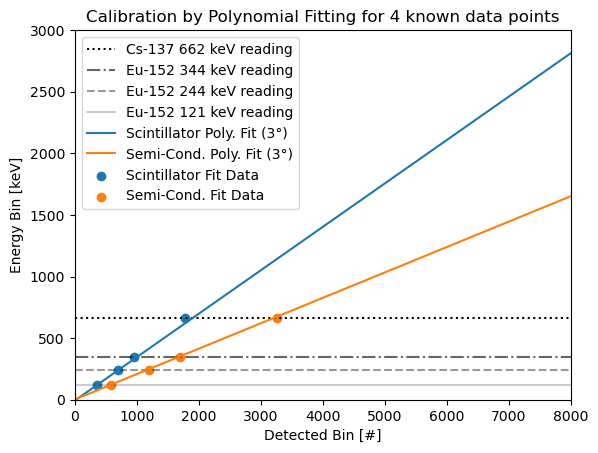

In [4]:
#CALIBRATION

#energy = [121.424,244.007,344.096,662.714]
energy = [121,244,344,662]
calscint, errs, x_orig, sorig = calibration('DATA/scint/Meas_Eu_152_Cal(actual).txt',energy)
calgerm, errg, x_orig, gorig = calibration('DATA/germ/Eu152(withtime).txt',energy)
print(calscint, errs)
print(calgerm,errg)

plt.title('Calibration by Polynomial Fitting for 4 known data points')
plt.plot([0,8000],[662,662], label = 'Cs-137 662 keV reading',alpha = 1, color = 'black', linestyle = ':')
plt.plot([0,8000],[344,344], label = 'Eu-152 344 keV reading',alpha = 0.6, color = 'black', linestyle = '-.')
plt.plot([0,8000],[244,244], label = 'Eu-152 244 keV reading',alpha = 0.4, color = 'black', linestyle = '--')
plt.plot([0,8000],[121,121], label = 'Eu-152 121 keV reading',alpha = 0.2, color = 'black')
plt.plot(x_orig, calscint[0]*x_orig+calscint[1]*x_orig+calscint[2]*x_orig+calscint[3], label = 'Scintillator Poly. Fit (3°)')
plt.plot(x_orig, calgerm[0]*x_orig+calgerm[1]*x_orig+calgerm[2]*x_orig+calgerm[3], label = 'Semi-Cond. Poly. Fit (3°)')
plt.scatter(sorig,energy, label = 'Scintillator Fit Data')
plt.scatter(gorig,energy, label = 'Semi-Cond. Fit Data')
plt.xlim(0,8000)
plt.ylim(0,3000)
plt.ylabel('Energy Bin [keV]')
plt.xlabel('Detected Bin [#]')
plt.legend()
plt.savefig('calibration.png')


C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file1, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file1, delim_whitespace=True)


66 62
9 0


C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file1, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_

1 0
100 63


C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file1, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_

12 1
16 0


C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file1, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)


4 0


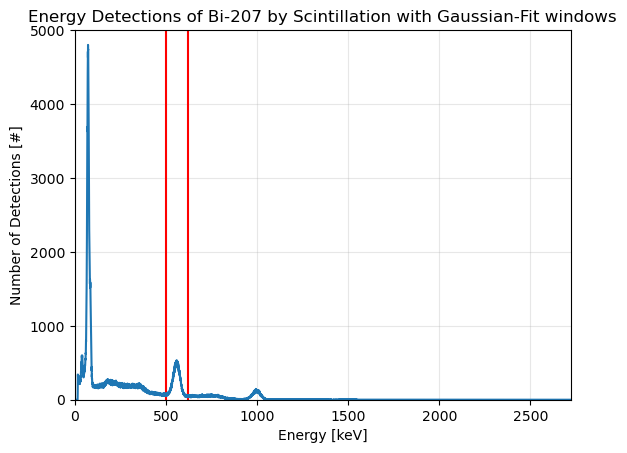

<Figure size 640x480 with 0 Axes>

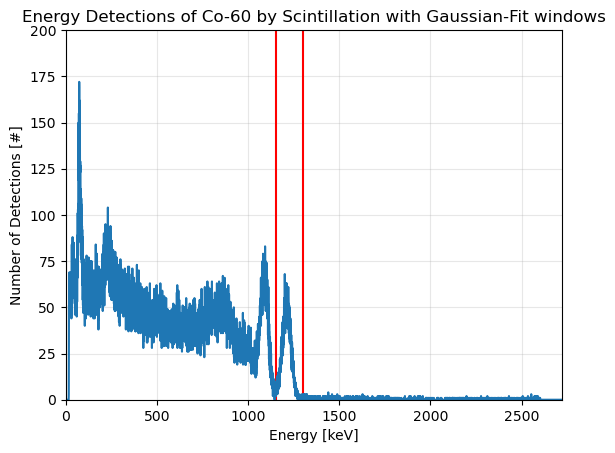

<Figure size 640x480 with 0 Axes>

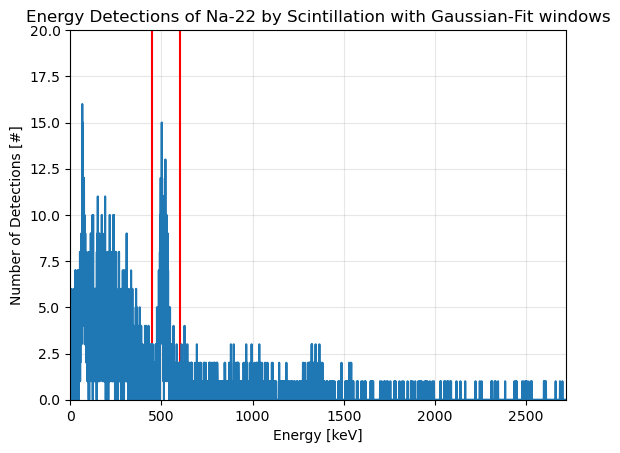

<Figure size 640x480 with 0 Axes>

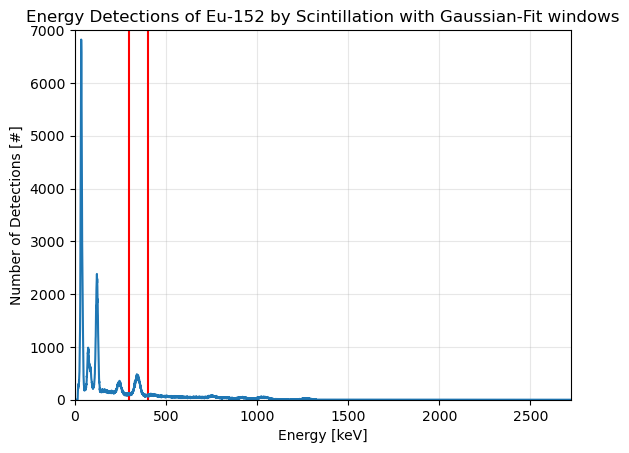

<Figure size 640x480 with 0 Axes>

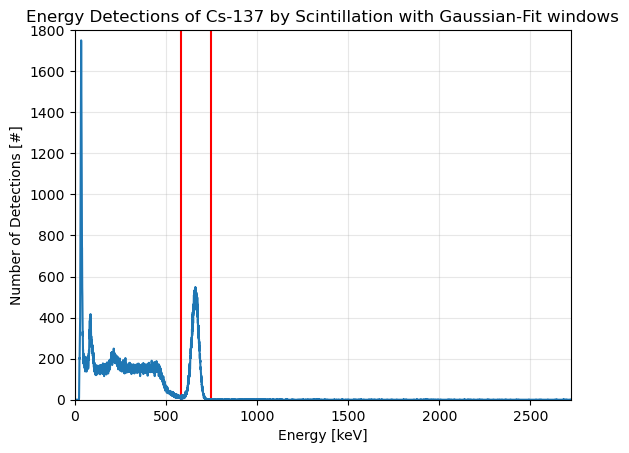

<Figure size 640x480 with 0 Axes>

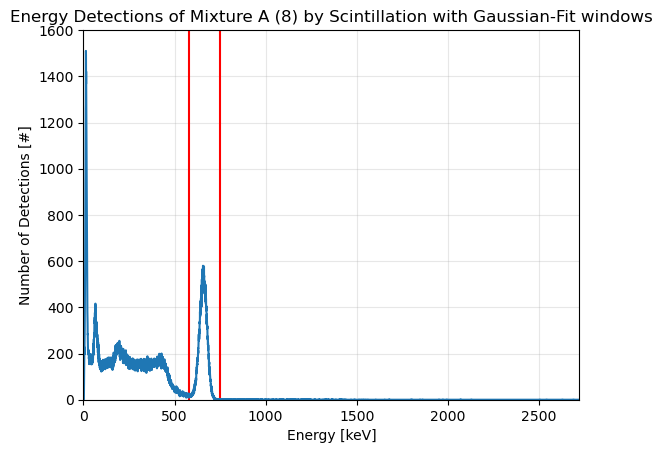

<Figure size 640x480 with 0 Axes>

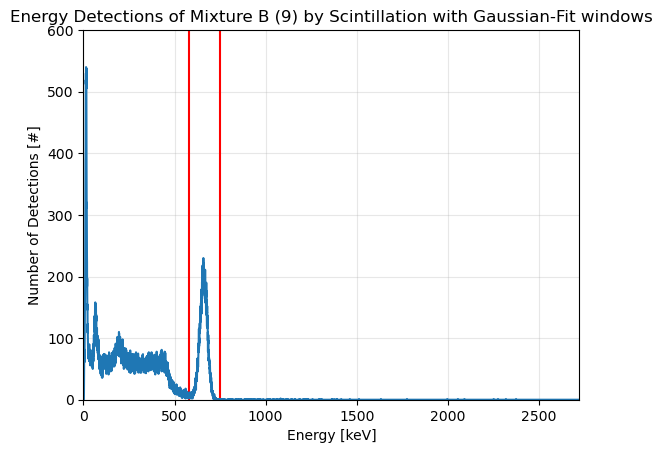

<Figure size 640x480 with 0 Axes>

In [5]:
#Scint Raw



filelocation=['DATA/scint/Meas_Bi_207(time available).txt','DATA/scint/Meas_Co_60(time available).txt','DATA/scint/toprak/Meas_Na_Calibrated.txt','DATA/scint/Meas_Eu_152_Cal(actual).txt','DATA/scint/Meas_CS_137_Cal(time available) .txt','DATA/scint/toprak/Meas_Gemisch_A_Calibrated.txt','DATA/scint/toprak/Meas_Gemisch_B_Calibrated.txt']
filesaves=['scint_bi','scint_co','scint_na','scint_eu','scint_cs','scint_8','scint_9']
filetitles=['Bi-207','Co-60','Na-22','Eu-152','Cs-137','Mixture A (8)','Mixture B (9)']
smean = np.zeros(len(filesaves))
sstddev = np.zeros(len(filesaves))
sresolution = np.zeros(len(filesaves))
ylims = [5000,200,20,7000,1800,1600,600]
xlim = [[500,620],[1150,1300],[450,600],[300,400],[580,750],[580,750],[580,750]]

for j in range(7):
    raw(filelocation[j],filesaves[j],'Energy Detections of '+filetitles[j]+' by Scintillation with Gaussian-Fit windows',2721,ylims[j],xlim[j])
    smean[j], sstddev[j], sresolution[j] = Gaussian_Fit(filelocation[j],False,xlim[j][0],xlim[j][1])
    

Element: ['Bi-207', 'Co-60', 'Na-22', 'Eu-152', 'Cs-137', 'Mixture A (8)', 'Mixture B (9)']
Energy: [ 558.19674187 1212.13732516  512.32203669  343.62998711  660.86446755
  658.0393569   660.08759862]
Standard deviation: [17.30625501 20.83603827 19.75340965 13.44710133 18.71350516 20.43111654
 20.59165252]
Resolution: [0.07300852 0.04047819 0.09079392 0.09215    0.06668075 0.07311356
 0.0734594 ]
max var: 1
Steigung a: 1.1516019751198137
Achsenabschnitt b: 169.7234968531267
R^2: 0.7172853464775618


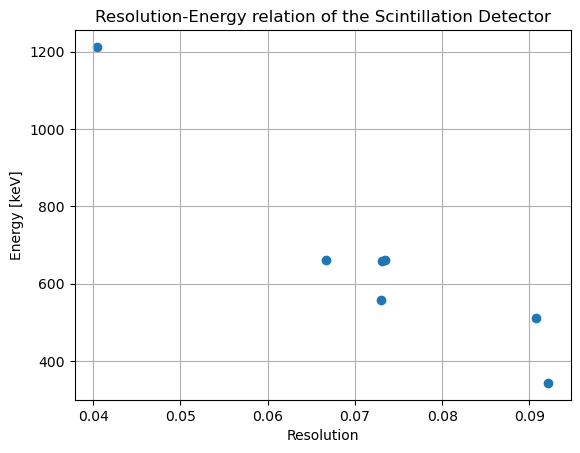

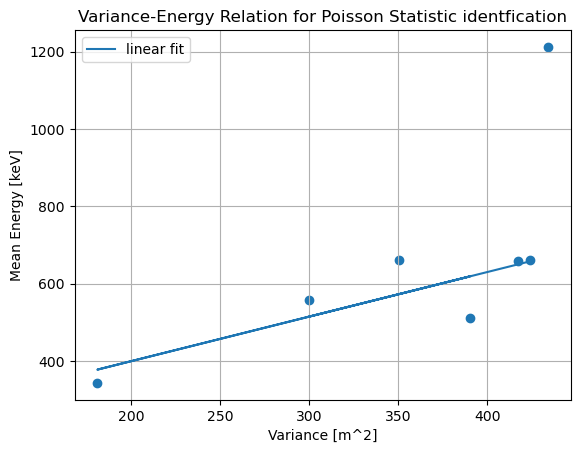

In [6]:
#Scint RESOLUTION!
print('Element:',filetitles)
print('Energy:',smean)
print('Standard deviation:',sstddev)
print('Resolution:',sresolution)


#plt.figure()
plt.xlabel('Resolution')
plt.ylabel('Energy [keV]')
plt.title('Resolution-Energy relation of the Scintillation Detector')
plt.grid()
plt.scatter(sresolution,smean)
plt.savefig('res_ene_sci.png')


plt.figure()
plt.grid()
plt.title('Variance-Energy Relation for Poisson Statistic identfication')
plt.scatter(sstddev**2,smean)
plt.xlabel('Variance [m^2]')
plt.ylabel('Mean Energy [keV]')


print('max var:', np.argmax(sstddev))
x = sstddev**2
y = smean
x = np.delete(x,np.argmax(sstddev))
y = np.delete(y,np.argmax(sstddev))

a, b = np.polyfit(x, y, 1)
# Residuen: beobachtetes y - vorhergesagtes y_fit
y_fit = a * x + b
residuals = y - y_fit
plt.plot(x,a*x+b,label = 'linear fit')
print("Steigung a:", a)
print("Achsenabschnitt b:", b)
# Residuen
ss_res = np.sum((y - y_fit)**2)

# totale Streuung
ss_tot = np.sum((y - np.mean(y))**2)

# R^2
r2 = 1 - ss_res / ss_tot

print("R^2:", r2)
plt.legend()


plt.savefig('var_ene_sci.png')

C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file1, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file1, delim_whitespace=True)


47 24
0 0


C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file1, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_

0 0
24 11


C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file1, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_

3 1
44 9


C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file1, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\3275954880.py:72: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True)


38 7


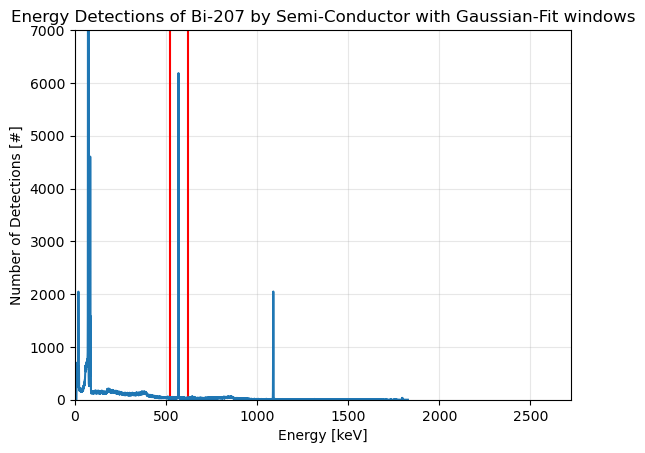

<Figure size 640x480 with 0 Axes>

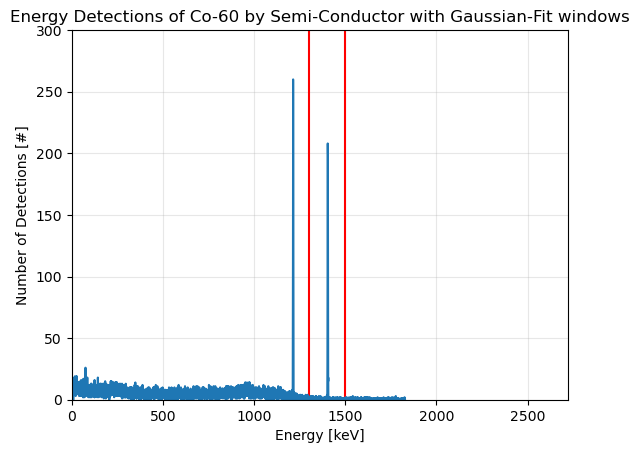

<Figure size 640x480 with 0 Axes>

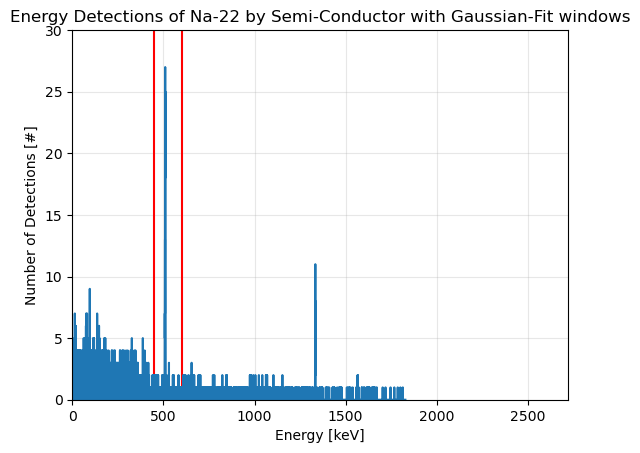

<Figure size 640x480 with 0 Axes>

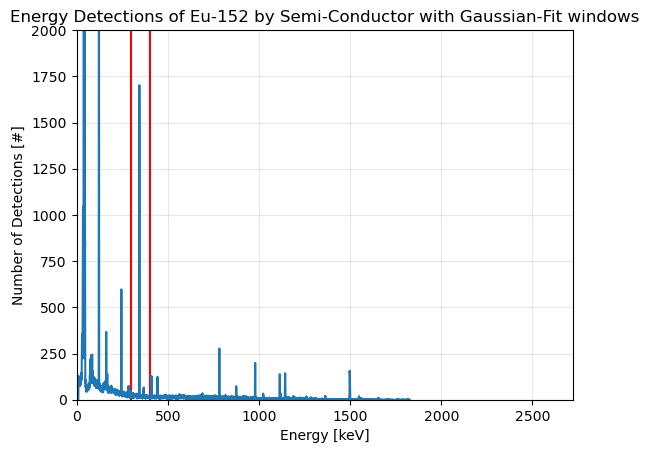

<Figure size 640x480 with 0 Axes>

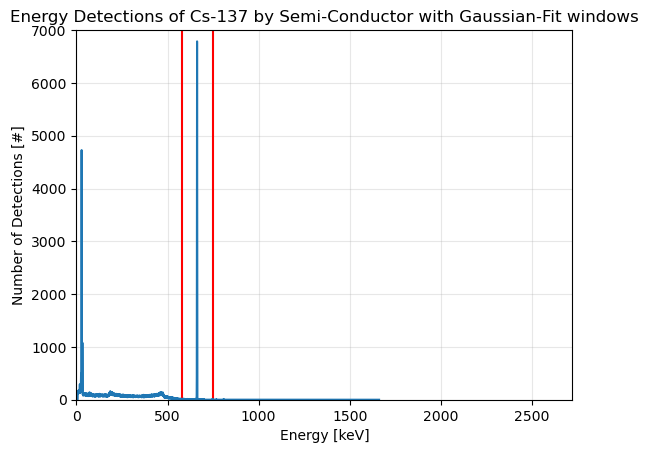

<Figure size 640x480 with 0 Axes>

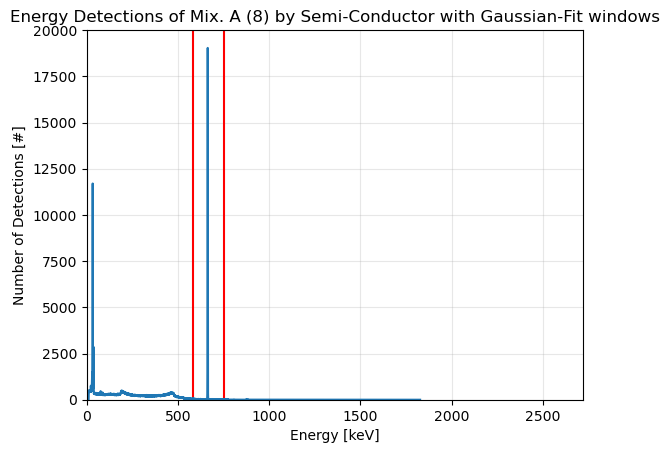

<Figure size 640x480 with 0 Axes>

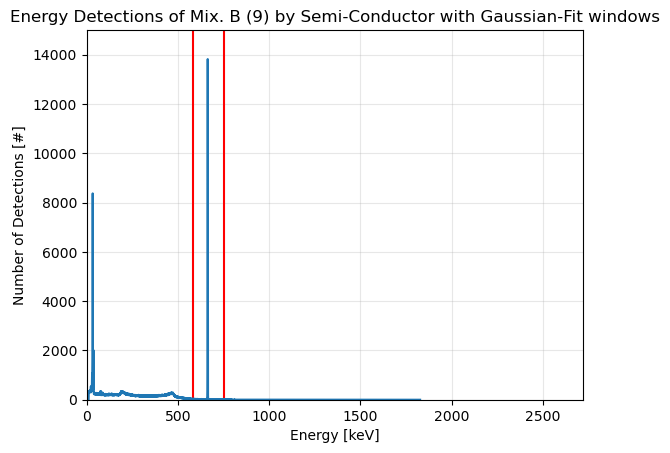

<Figure size 640x480 with 0 Axes>

In [7]:
#Germ Raw
gmean = np.zeros(len(filesaves))
gstddev = np.zeros(len(filesaves))
gresolution = np.zeros(len(filesaves))


filelocation=['DATA/germ/Bi207(withtime).txt','DATA/germ/Co60(withtime).txt','DATA/germ/Na22(withtime).txt','DATA/germ/Eu152(withtime).txt','DATA/germ/Cs137(withtime).txt','DATA/germ/Mystery9A(withtime).txt','DATA/germ/Mystery8B(withtime).txt']
filesaves=['germ_bi','germ_co','germ_na','germ_eu','germ_cs','germ_8','germ_9']
filetitles=['Bi-207','Co-60','Na-22','Eu-152','Cs-137','Mix. A (8)','Mix. B (9)']
ylims = [7000,300,30,2000,7000,20000,15000]
xlim = [[520,620],[1300,1500],[450,600],[300,400],[580,750],[580,750],[580,750]]

for j in range(7):
    raw(filelocation[j],filesaves[j],'Energy Detections of '+filetitles[j]+' by Semi-Conductor with Gaussian-Fit windows',2721,ylims[j],xlim[j])
    gmean[j], gstddev[j], gresolution[j] = Gaussian_Fit(filelocation[j],False,xlim[j][0],xlim[j][1])
    gstddev[j] = np.abs(gstddev[j])
    gresolution[j] = np.abs(gresolution[j])



Element: ['Bi-207', 'Co-60', 'Na-22', 'Eu-152', 'Cs-137', 'Mix. A (8)', 'Mix. B (9)']
Energy: [ 568.96437344 1403.99748841  510.11777185  344.00619001  662.00752093
  662.10593199  662.07991375]
Standard deviation: [0.61278403 1.00327594 1.22080316 0.50673201 0.62182454 0.66189367
 0.65629038]
Resolution: [0.00253618 0.00168272 0.00563551 0.00346872 0.00221189 0.00235407
 0.00233423]
max var: 2
Steigung a: 1341.2484390802047
Achsenabschnitt b: 70.19090904509422
R^2: 0.9831034811764965


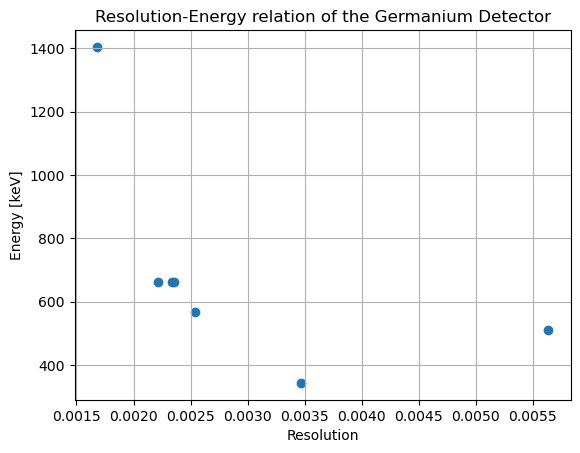

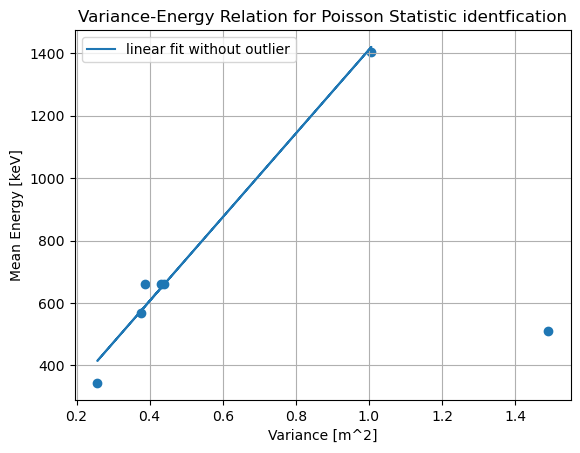

In [8]:
#Germ RESOLUTION!
print('Element:',filetitles)
print('Energy:',gmean)
print('Standard deviation:',gstddev)
print('Resolution:',gresolution)

j = 6
#Gaussian_Fit(filelocation[j],True,xlim[j][0],xlim[j][1])
plt.figure()
plt.xlabel('Resolution')
plt.ylabel('Energy [keV]')
plt.title('Resolution-Energy relation of the Germanium Detector')
plt.grid()
plt.scatter(gresolution,gmean)
plt.savefig('res_ene_ger.png')


plt.figure()
plt.grid()
plt.title('Variance-Energy Relation for Poisson Statistic identfication')
plt.scatter(gstddev**2,gmean)
plt.xlabel('Variance [m^2]')
plt.ylabel('Mean Energy [keV]')

print('max var:', np.argmax(gstddev))
x = gstddev**2
y = gmean
x = np.delete(x,np.argmax(gstddev))
y = np.delete(y,np.argmax(gstddev))

a, b = np.polyfit(x, y, 1)
# Residuen: beobachtetes y - vorhergesagtes y_fit
y_fit = a * x + b
residuals = y - y_fit
plt.plot(x,a*x+b,label = 'linear fit without outlier')
print("Steigung a:", a)
print("Achsenabschnitt b:", b)
# Residuen
ss_res = np.sum((y - y_fit)**2)

# totale Streuung
ss_tot = np.sum((y - np.mean(y))**2)

# R^2
r2 = 1 - ss_res / ss_tot

print("R^2:", r2)
plt.legend()


plt.savefig('var_ene_ger.png')

C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\1694902432.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file1, delim_whitespace=True)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_5680\1694902432.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(step_function, energy1, reading1, p0=initial_guess)


[480.          11.23761229 184.06124031]


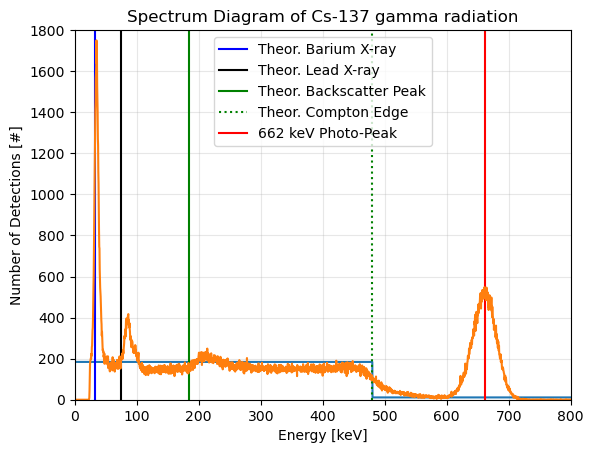

In [21]:
# Cesium Disection

def step_function(x, threshold, low_value, high_value):
    """Step function with parameters to fit"""
    return np.where(x <= threshold, high_value, low_value)


def raw_alt(file1,filename,title,xlim,ylim):
    df = pd.read_csv(file1, delim_whitespace=True)
    
    energy1 = df['Energy'].to_numpy()#MeV
    reading1 = df['Readings'].to_numpy()
    plt.figure()
    plt.grid(True, alpha = 0.3)
    plt.ylabel('Number of Detections [#]')
    plt.xlabel('Energy [keV]')
    initial_guess = [480,20,200]  # [threshold, low_value, high_value]
    params, covariance = curve_fit(step_function, energy1, reading1, p0=initial_guess)
    print(params)
    plt.plot(energy1,step_function(energy1,params[0],params[1],params[2]))
    plt.plot([32.14,32.14],[0,100000], color = 'blue',label = 'Theor. Barium X-ray')
    plt.plot([75,75],[0,100000], color = 'black',label = 'Theor. Lead X-ray')
    plt.plot([184,184],[0,100000], color = 'green',label = 'Theor. Backscatter Peak')
    plt.plot([480,480],[0,100000], color = 'green',label = 'Theor. Compton Edge',linestyle = 'dotted')
    plt.plot([662,662],[0,100000], color = 'red',label = '662 keV Photo-Peak')
    plt.legend()
    plt.xlim(0,xlim)
    plt.ylim(0,ylim)
    plt.plot(energy1,reading1)
    plt.title(title)
    plt.savefig(filename + '.png')

raw_alt('DATA/scint/Meas_CS_137_Cal(time available) .txt','cs_detail','Spectrum Diagram of Cs-137 gamma radiation',800,1800)
